# Graphistasis

![Graphistasis](assets/Logo.png)

Using a Graph Neural Network to mine gene-gene (epistatic) interactions for neurologic disease in the BioSNAP DGMiner dataset.

### Set up .venv
```bash
brew install uv
uv init
uv venv --python 3.11
source .venv/bin/activate

uv add torch==2.6.0 torch_geometric pandas numpy matplotlib seaborn scikit-learn tqdm pip ipykernel biopython pymedtermino

export PYTORCH_ENABLE_MPS_FALLBACK=1
# pip install pyg-lib
```

### Import libraries

In [1]:
from scripts.utils import *
from scripts.gnn_utils import *
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

2.6.0
2.6.1


In [2]:
!pip install torch==2.6.0

In [2]:
pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+$cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+.html
  Using cached torch_sparse-0.6.18-cp311-cp311-macosx_11_0_arm64.whl
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip uninstall torch-sparse -y
!pip install --upgrade setuptools wheel
!pip install --no-build-isolation --verbose git+https://github.com/rusty1s/pytorch_sparse.git

Found existing installation: torch_sparse 0.6.18
Uninstalling torch_sparse-0.6.18:
  Successfully uninstalled torch_sparse-0.6.18
Using pip 25.1.1 from /Users/mananspancholy/Documents/GitHub/graphistasis/.venv/lib/python3.11/site-packages/pip (python 3.11)
  Cloning https://github.com/rusty1s/pytorch_sparse.git to /private/var/folders/b7/ytms26m50vx97fphcwvt3gpr0000gn/T/pip-req-build-akm9ouku
  Running command git version
  git version 2.39.3 (Apple Git-145)
  Running command git clone --filter=blob:none https://github.com/rusty1s/pytorch_sparse.git /private/var/folders/b7/ytms26m50vx97fphcwvt3gpr0000gn/T/pip-req-build-akm9ouku
  Cloning into '/private/var/folders/b7/ytms26m50vx97fphcwvt3gpr0000gn/T/pip-req-build-akm9ouku'...
  Running command git rev-parse HEAD
  6f8668031ef8e7b63ac7d86ce82cb8390a189a00
  Resolved https://github.com/rusty1s/pytorch_sparse.git to commit 6f8668031ef8e7b63ac7d86ce82cb8390a189a00
  Running command git submodule update --init --recursive -q
  Running comma

In [3]:
import torch_scatter
import torch_sparse

### Run Data Set Up
```bash
bash scripts/unpack.sh
```

### Filter the dataset

In [2]:
# All genes
all = filter_data()

Reading in DGMiner TSV file as DataFrame object...
Filtering out missing values...
Cleaning disease names...
Dropping diseases that don't start with 'D'...


In [3]:
diseases = pd.unique(all['# Disease(MESH)']).tolist()

In [4]:
# # Map the disease names from their MESH IDs
# mesh_to_disease = mesh_to_name(diseases)
# with open('data/mesh_to_disease.json', 'w') as f:
#     json.dump(mesh_to_disease, f)

In [4]:
# Load the data
with open('data/mesh_to_disease.json', 'r') as f:
    mesh_to_disease = json.load(f)

### Create the Epistatic Interaction Dataset

In [5]:
# Uniprot to Gene Names
all_uniprot = pd.unique(all['Gene'])
with open('data/all_uniprot.txt', 'w') as f:
    for gene in all_uniprot:
        f.write(f"{gene}\n")

Upload the text file to this [website](https://www.uniprot.org/id-mapping). It will convert the Uniprot IDs to Gene names.

In [6]:
# Mapping dictionary
uniprot_to_gene, gene_to_uniprot, from_to = create_mappings(file_path='data/gene_mapping.tsv')

In [7]:
access_key = "97121fd52d13c24ff0ac6d80d8f0266e"
all_genes = pd.unique(from_to.To)
gene_list = all_genes.tolist()

Retrieve Epistatic Interaction data from BioGrid

In [9]:
# # Fetching epistatic interactions
# gene_interactions = fetch_epistatic_interactions(gene_list, access_key)
# with open('data/gene_interactions.json', 'w') as f:
#     json.dump(gene_interactions, f)

In [8]:
# Loading the epistatic interactions
with open('data/gene_interactions.json', 'r') as f:
    interactions = json.load(f)

### Clean up the dataset

In [9]:
all_dg = clean_and_map_data(all, uniprot_to_gene, mesh_to_disease, 'data/all_DG_clean.tsv')

### Generate the Epistatic Interaction tsv file

In [12]:
# generate_epistatic_interactions_tsv(interactions, gene_list, "data/epistatic_interactions.tsv")

### Generate the Graph

In [3]:
epistatic_graph = generate_graph_from_tsv("data/epistatic_interactions.tsv")
save_graph(epistatic_graph, "graphs/epistatic_interactions.gml")

TypeError: generate_graph_from_tsv() missing 1 required positional argument: 'tsv_type'

In [57]:
epistatic_graph = load_graph("graphs/epistatic_interactions.gml")

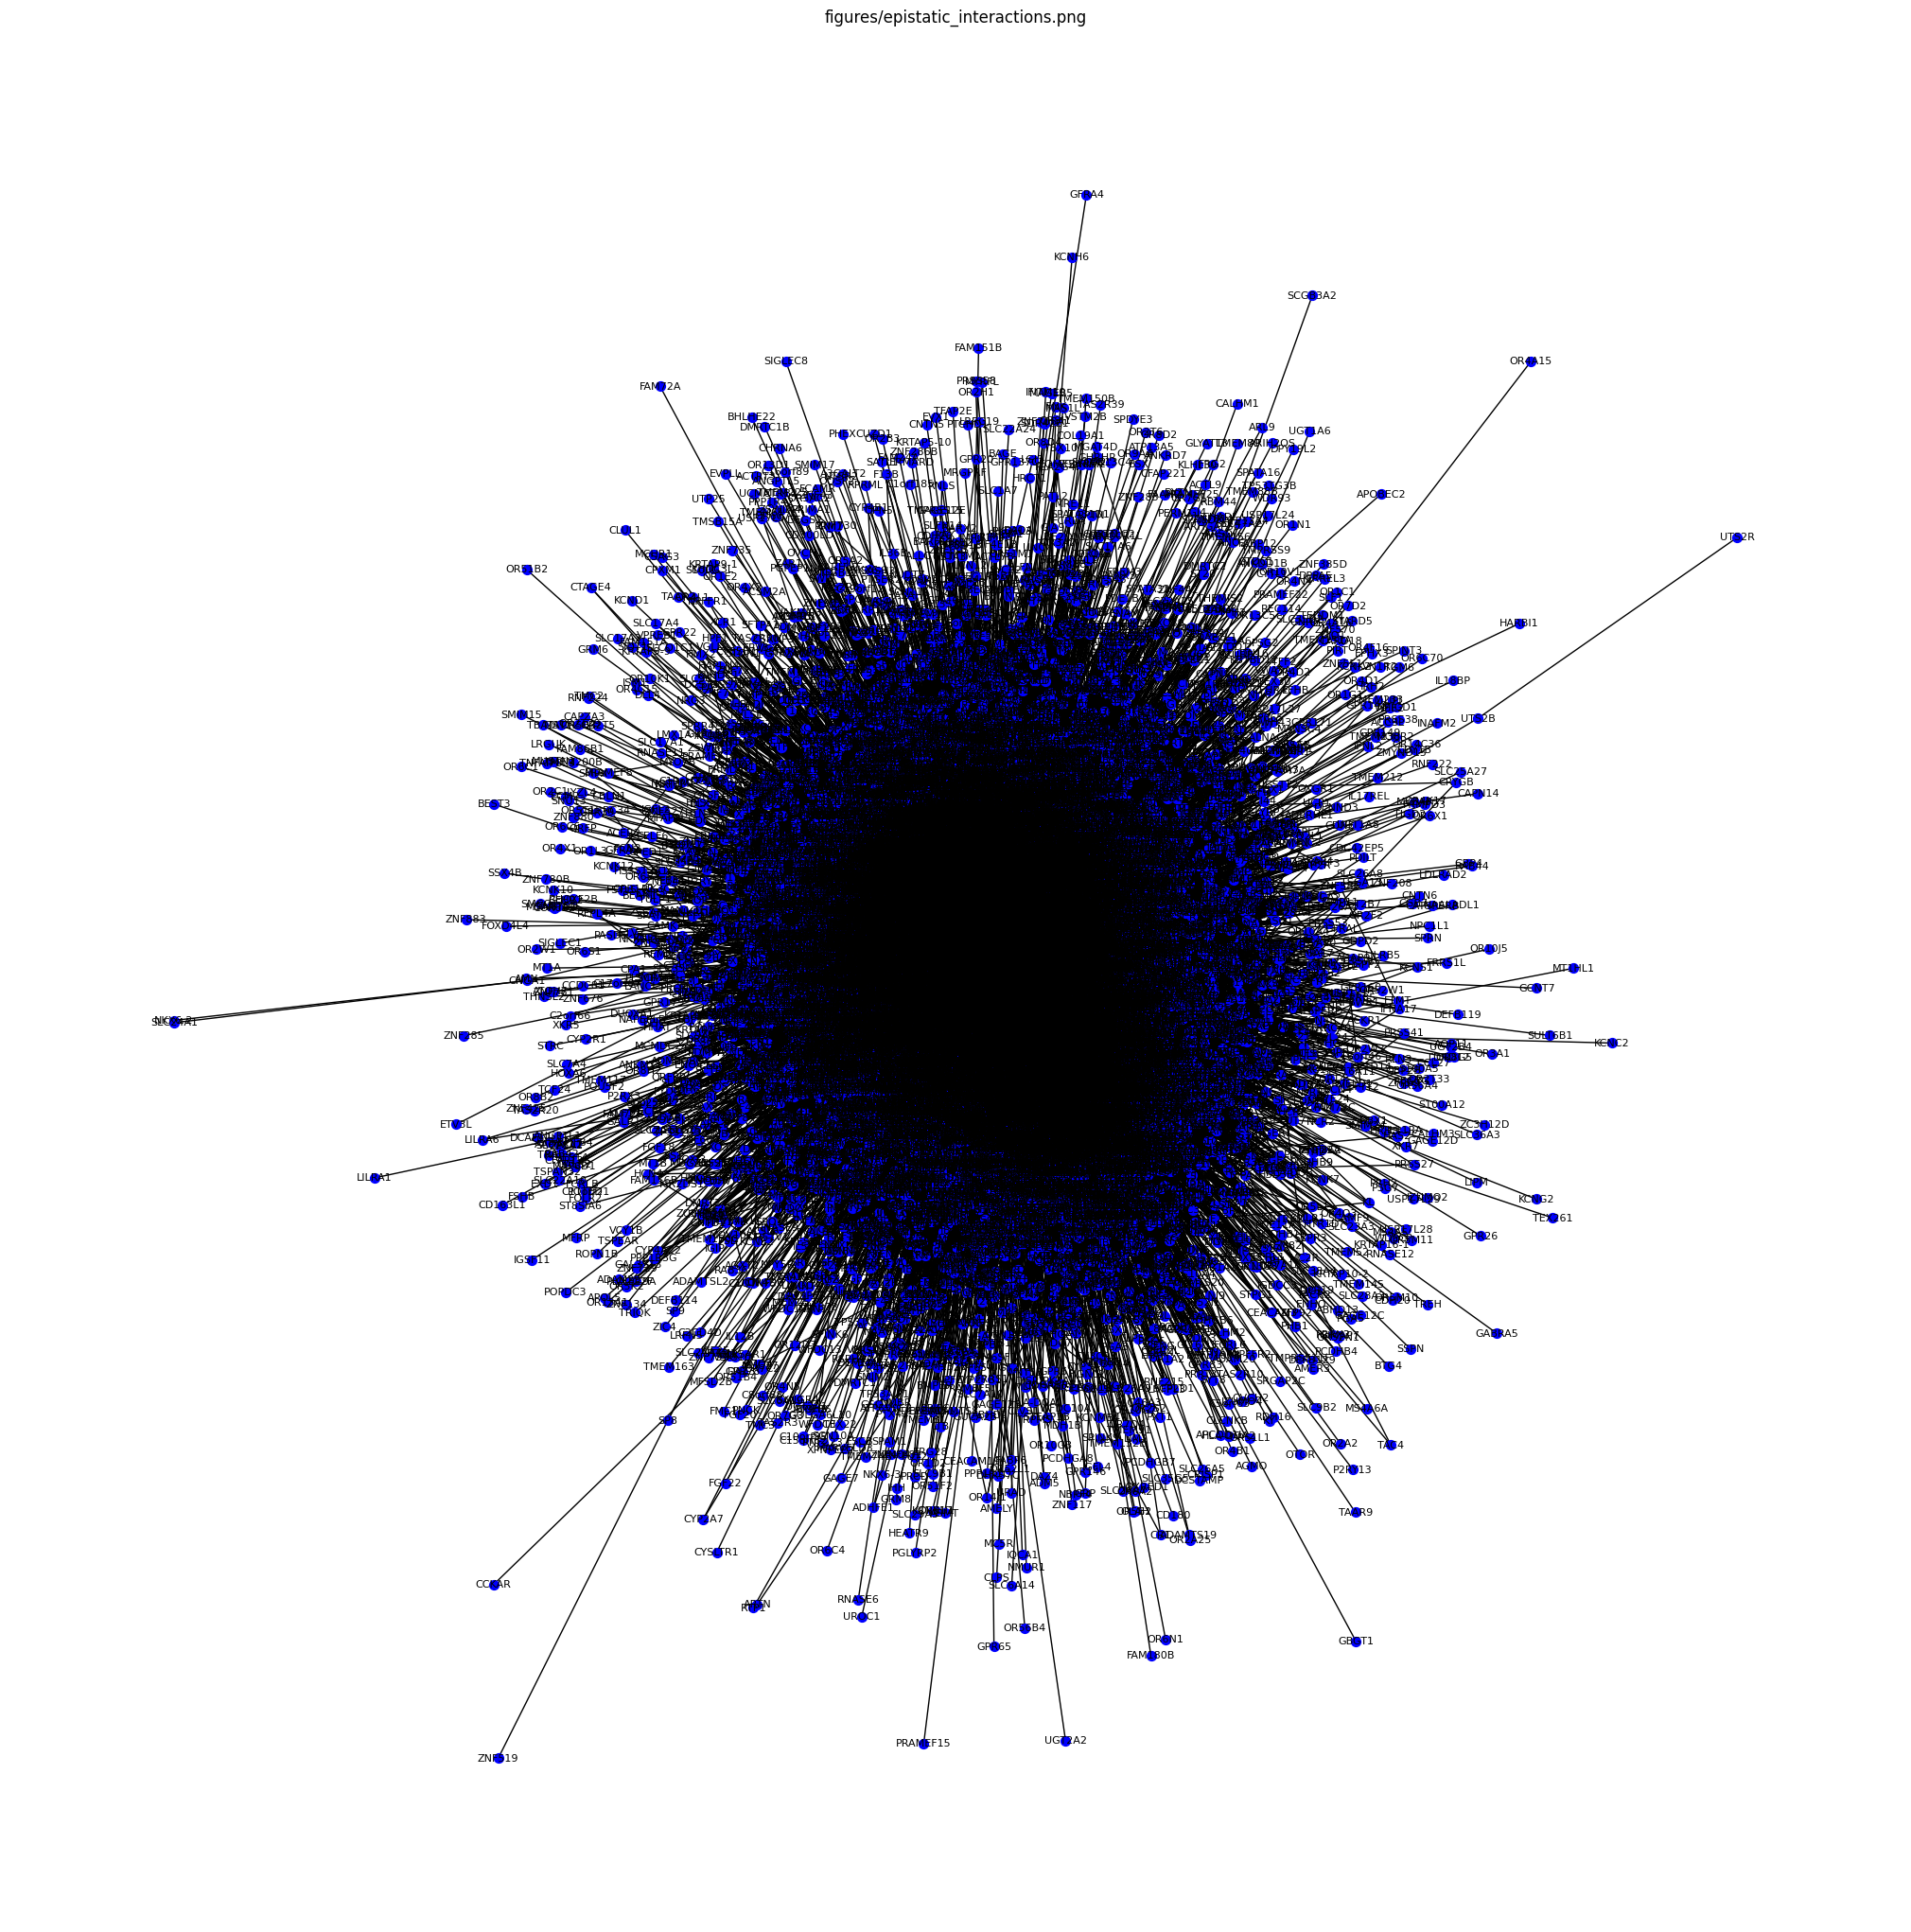

In [15]:
plot_graph(epistatic_graph, "figures/epistatic_interactions.png")

In [58]:
dg_graph = generate_graph_from_tsv("data/all_DG_clean.tsv")
save_graph(dg_graph, "graphs/dg_graph.gml")

/Users/mananspancholy/Documents/GitHub/graphistasis/scripts/utils.py:317: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(row[0], row[1])


Graph saved to graphs/dg_graph.gml


In [59]:
dg_graph = load_graph("graphs/dg_graph.gml")

KeyboardInterrupt: 

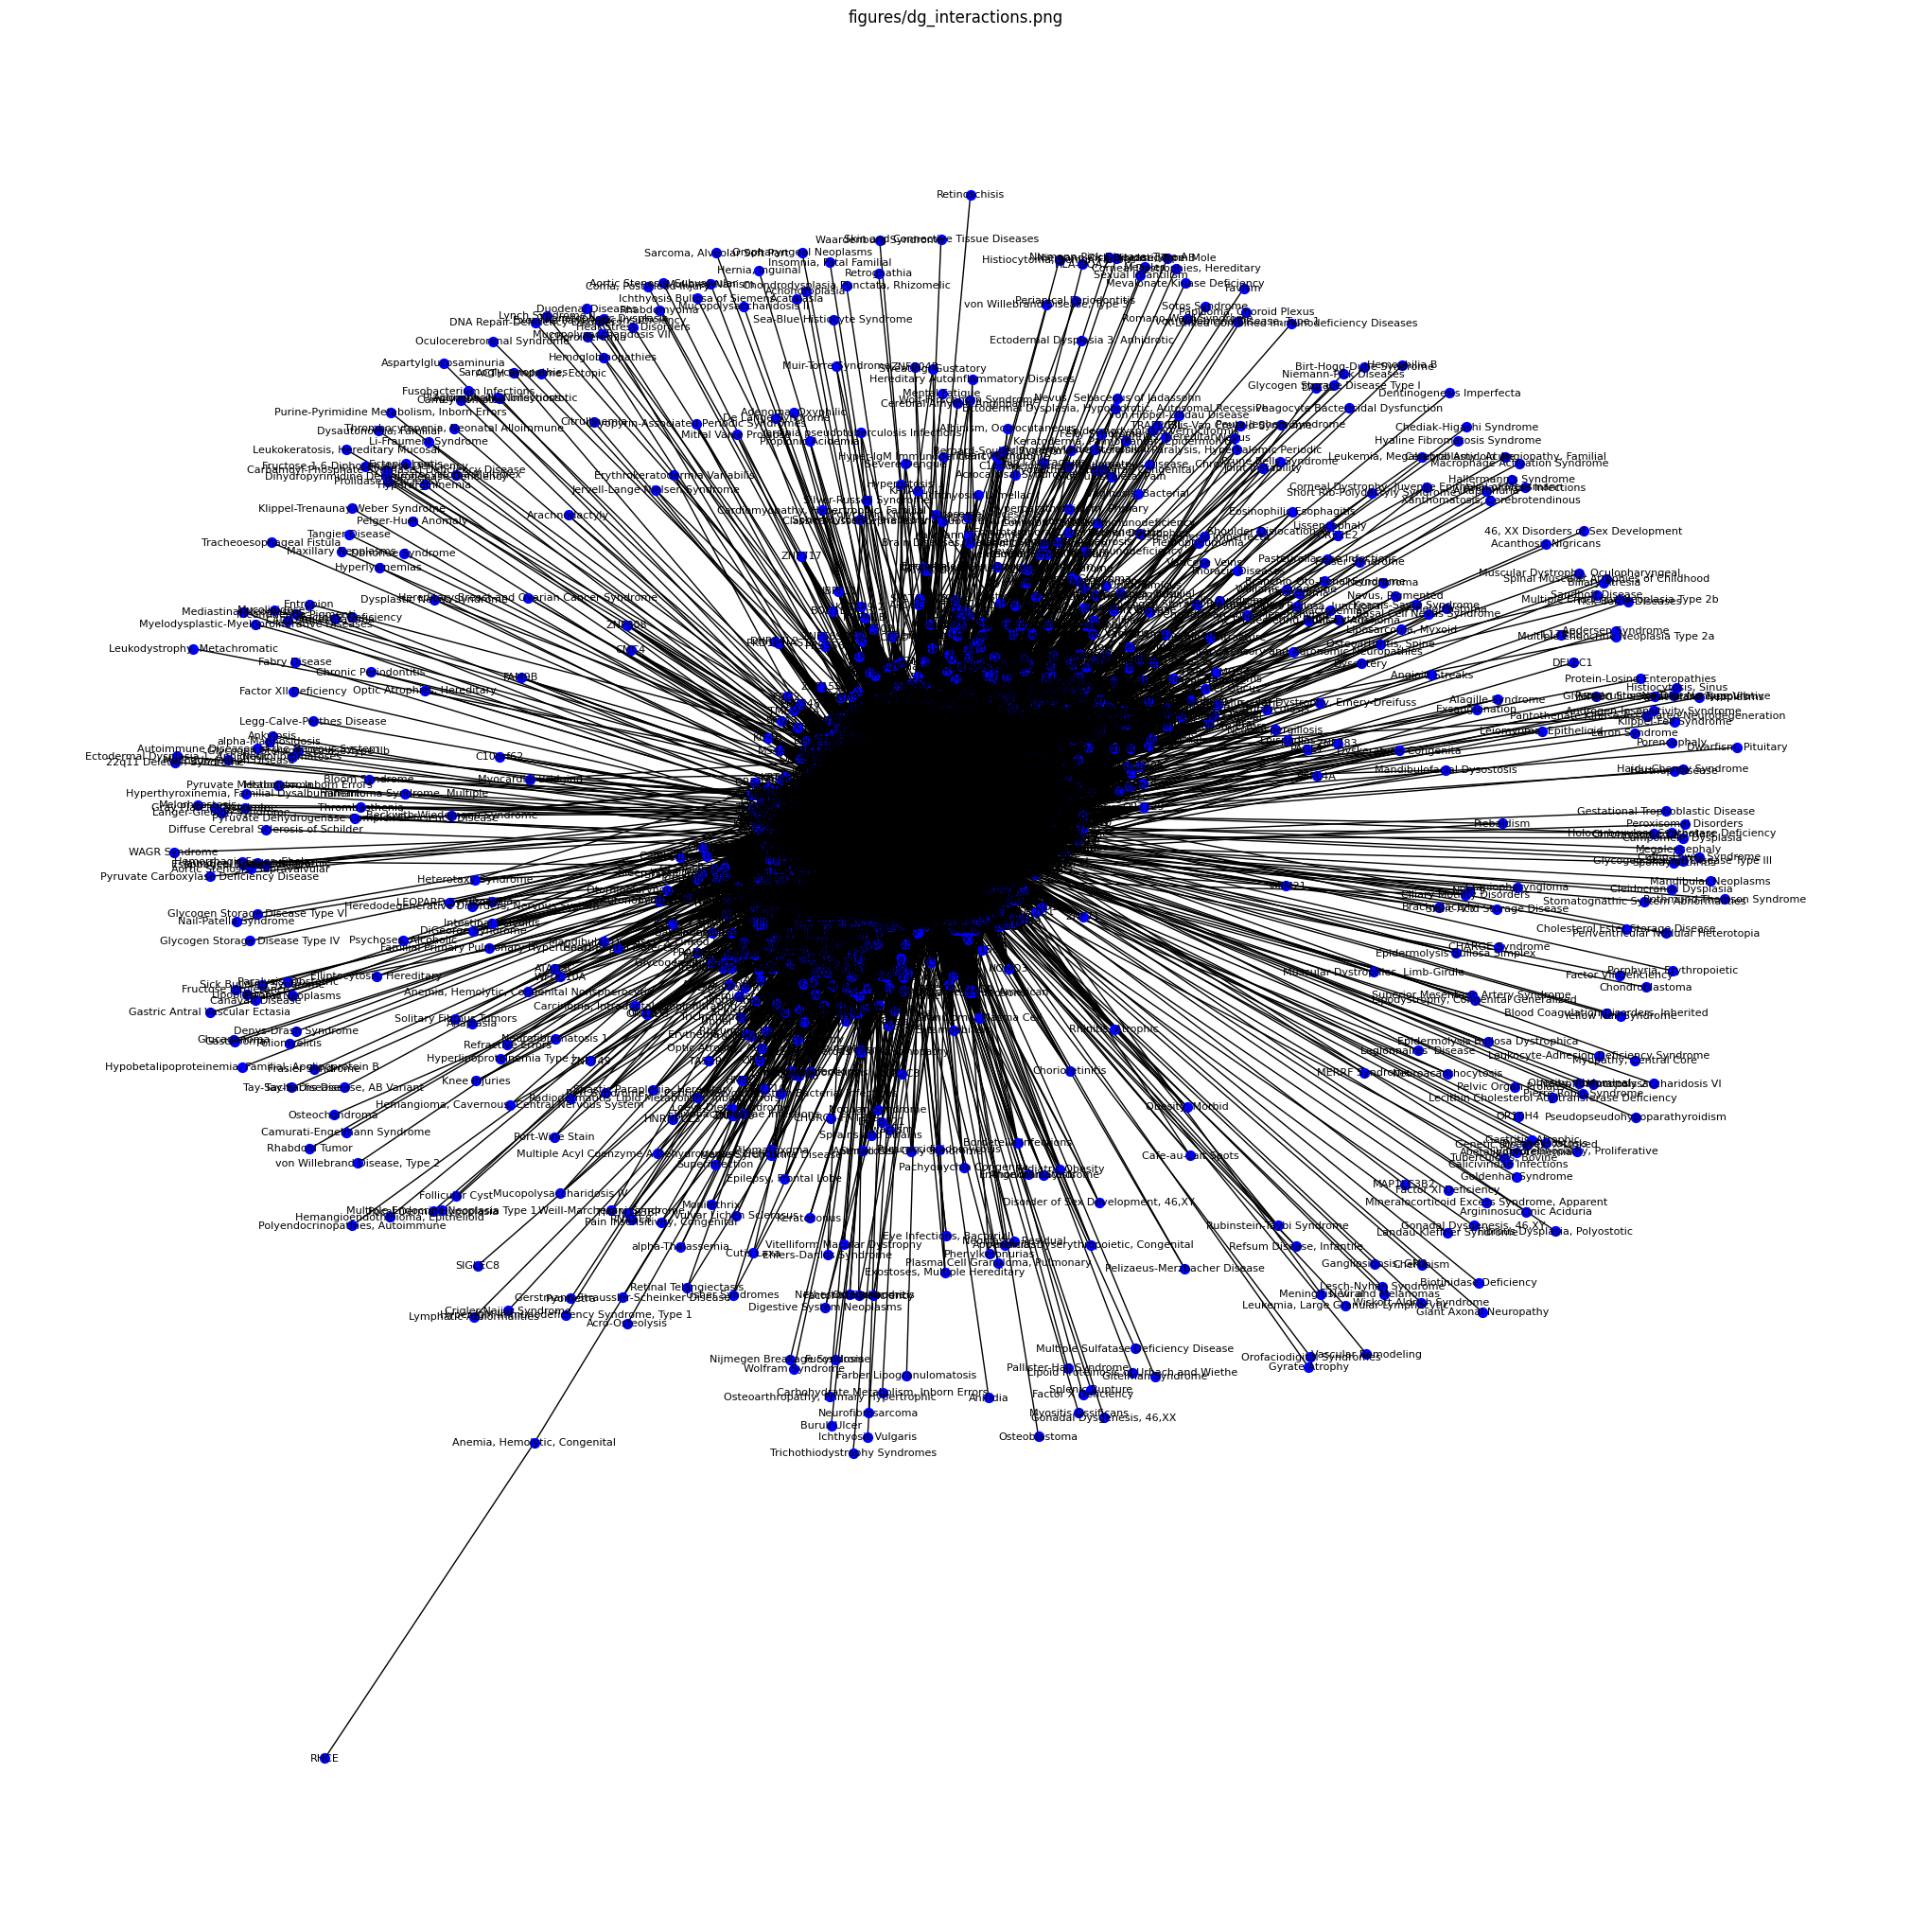

In [18]:
plot_graph(dg_graph, "figures/dg_interactions.png")

In [3]:
combined_graph = combine_graphs(epistatic_graph, dg_graph)
save_graph(combined_graph, "graphs/combined_graph.gml")

NameError: name 'epistatic_graph' is not defined

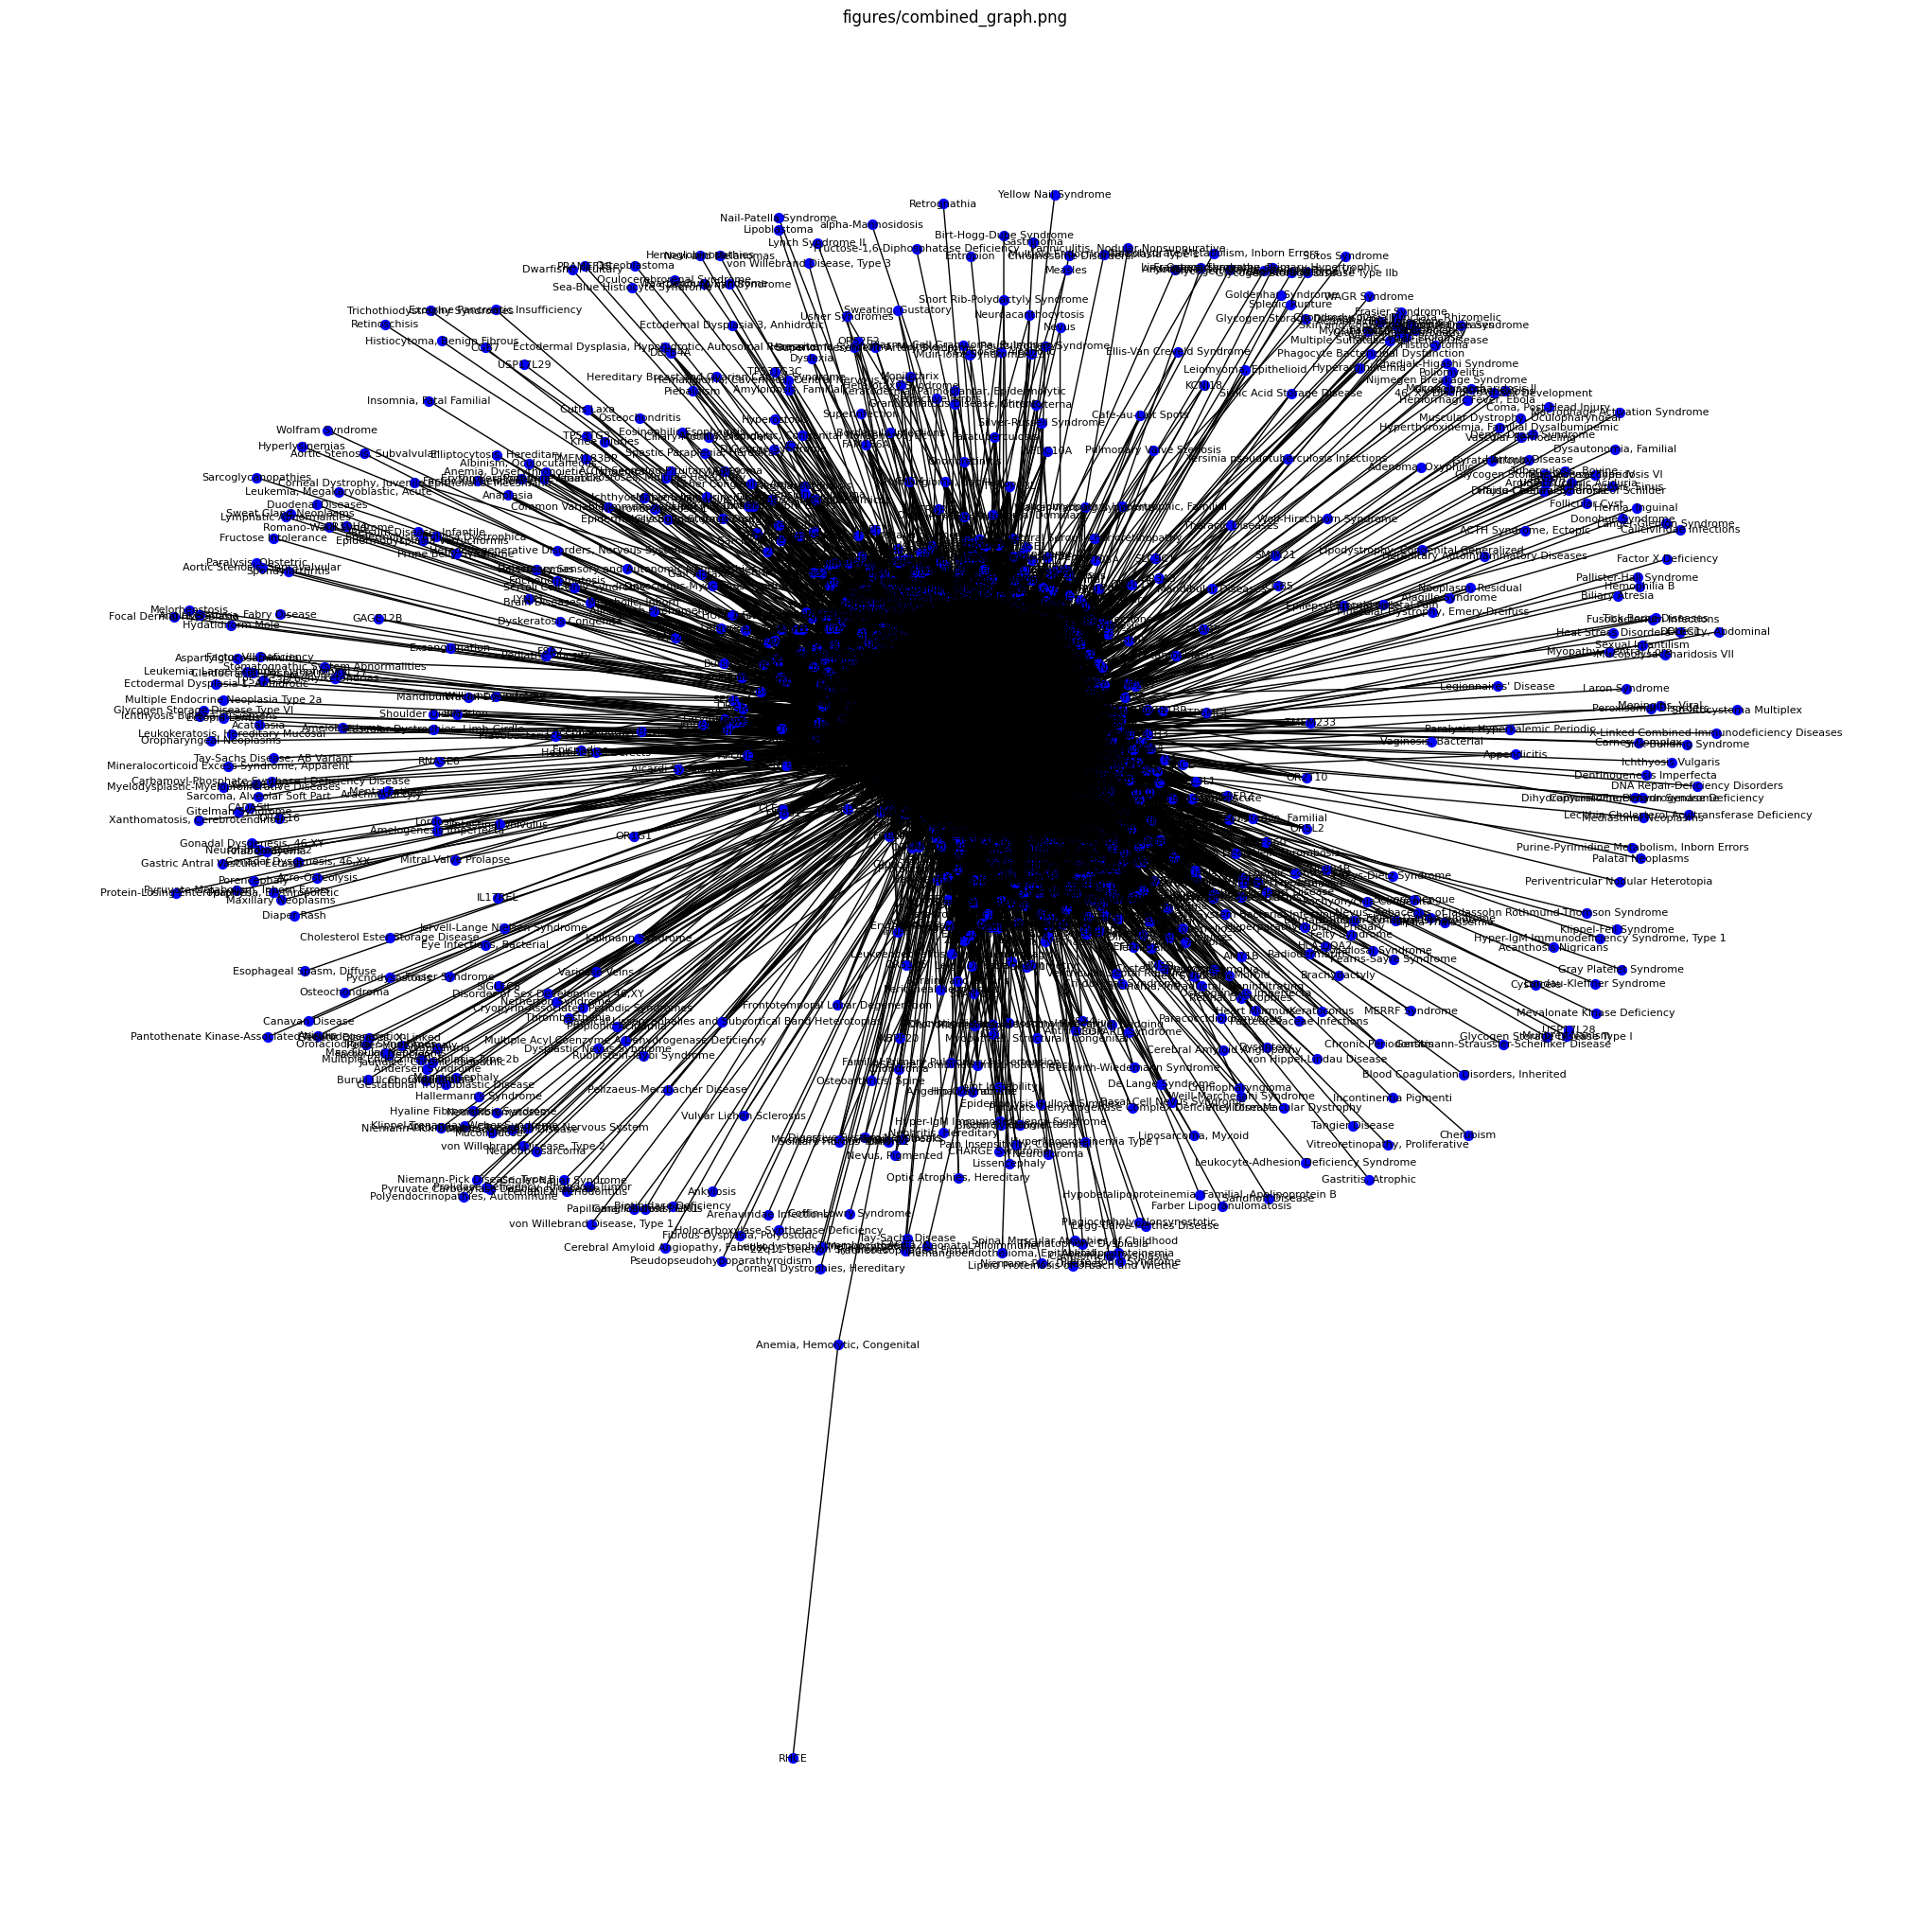

In [20]:
plot_graph(combined_graph, "figures/combined_graph.png")

## GNN Model
### Data Preparation

In [4]:
# Regenerate the graphs with proper node attributes
epistatic_graph = generate_graph_from_tsv("data/epistatic_interactions.tsv", tsv_type="GG")
# small_epistatic_graph = generate_graph_from_tsv("data/small_ei.tsv", tsv_type="GG")
# dg_graph = generate_graph_from_tsv("data/all_DG_clean.tsv", tsv_type="DG")
# combined_graph = combine_graphs(epistatic_graph, dg_graph)

/Users/mananspancholy/Documents/GitHub/graphistasis/scripts/utils.py:326: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene1 = row[0]
/Users/mananspancholy/Documents/GitHub/graphistasis/scripts/utils.py:327: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene2 = row[1]


In [5]:
# Prepare the GNN data using the combined graph
# pyg_data, properties = prepare_data(combined_graph)
# Prepare the GNN data using the epistatic graph
pyg_train, pyg_validation, pyg_test, properties = prepare_data(epistatic_graph)
# print(pyg_data.__dict__)

Idx -> [Gene, Disease] mapping done
After setting embeddings, x shape: torch.Size([16208, 1536])
After setting degrees, x shape: torch.Size([16208, 1536])
x.shape[0]: 16208
edge_index.max(): tensor(16207)
Name removed from pyg_data


In [6]:
# Debugging prepare_data 
print(pyg_train)
print(hasattr(pyg_train, 'edge_label_index'))
print(hasattr(pyg_train, 'edge_label'))
# print("prepare_data: node_type_list set?", properties[0])
# print("prepare_data: idx_to_gene set?", properties[1])

# if pyg_data.edge_index.max() >= pyg_data.x.shape[0] or pyg_data.edge_index.min() < 0:
#     print("Edge index out of bounds! Max:", pyg_data.edge_index.max().item(), "Num nodes:", pyg_data.x.shape[0])
# else:
#     print("Edge index is within bounds. Max:", pyg_data.edge_index.max().item(), "Num nodes:", pyg_data.x.shape[0])

# print("edge_index dtype:", pyg_data.edge_index.dtype)
# print("edge_index shape:", pyg_data.edge_index.shape)
# print("x dtype:", pyg_data.x.dtype)
# print("x shape:", pyg_data.x.shape)
# print("Max edge index:", pyg_data.edge_index.max().item())
# print("Min edge index:", pyg_data.edge_index.min().item())
# print("node_type_list (first 10):", properties[0][:10])
# print("Number of gene nodes:", sum([t == 1 for t in properties[0]]))
# print("idx_to_gene (first 10):", dict(list(properties[1].items())[:10]))

Data(edge_index=[2, 1039198], node_type=[16208], num_nodes=16208, x=[16208, 1536], edge_label=[1039198], edge_label_index=[2, 1039198])
True
True


In [7]:
# # Move to GPU if available
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# for K, V in pyg_data:
#     if torch.is_tensor(V):
#         pyg_data[K] = V.to(device)

In [7]:
model_constructor_args = {
    # 'in_channels' will be set by run_training_pipeline based on train_pyg.num_node_features
    'hidden_channels': 64,
    'out_channels': 16,
    'conv_type': 'SAGE' 
}

trained_model, training_history, final_test_metrics = run_training_pipeline(
    model_class=GraphiStasis,
    model_args=model_constructor_args,
    train_data=pyg_train,
    val_data=pyg_validation,
    test_data=pyg_test,
    epochs=50, # Adjust
    learning_rate=1e-4, # Adjust
    early_stopping_patience=10, # Adjust
    eval_batch_size=2048 # For evaluation progress bar
)

# # Instantiate the model
# model = GraphiStasis(in_channels, hidden_channels, out_channels, conv_type='SAGE')
# model.to(device)

# # Train the model
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# loss_fxn = torch.nn.BCEWithLogitsLoss()
# epochs = 5

# losses = mini_batch_train_link_prediction(model, 
#                                           pyg_data, 
#                                           optimizer, 
#                                           loss_fxn, 
#                                           properties,
#                                           epochs,
#                                           batch_size=512,
#                                           num_neighbors=[10, 10])

Using device: cpu


Overall Epochs:   2%|▏         | 1/50 [00:01<01:36,  1.96s/it]


Epoch 001 Summary: Train Loss: 0.6941, Val ROC AUC: 0.5370, Val Avg Precision: 0.0243


Overall Epochs:   4%|▍         | 2/50 [00:03<01:28,  1.84s/it]


Epoch 002 Summary: Train Loss: 0.6940, Val ROC AUC: 0.5648, Val Avg Precision: 0.0382


Overall Epochs:   6%|▌         | 3/50 [00:05<01:24,  1.81s/it]


Epoch 003 Summary: Train Loss: 0.6938, Val ROC AUC: 0.5914, Val Avg Precision: 0.0580


Overall Epochs:   8%|▊         | 4/50 [00:07<01:22,  1.79s/it]


Epoch 004 Summary: Train Loss: 0.6938, Val ROC AUC: 0.6135, Val Avg Precision: 0.0767


Overall Epochs:  10%|█         | 5/50 [00:09<01:20,  1.79s/it]


Epoch 005 Summary: Train Loss: 0.6937, Val ROC AUC: 0.6311, Val Avg Precision: 0.0920


Overall Epochs:  12%|█▏        | 6/50 [00:10<01:18,  1.77s/it]


Epoch 006 Summary: Train Loss: 0.6936, Val ROC AUC: 0.6450, Val Avg Precision: 0.1040


Overall Epochs:  14%|█▍        | 7/50 [00:12<01:16,  1.78s/it]


Epoch 007 Summary: Train Loss: 0.6936, Val ROC AUC: 0.6561, Val Avg Precision: 0.1139


Overall Epochs:  16%|█▌        | 8/50 [00:14<01:15,  1.79s/it]


Epoch 008 Summary: Train Loss: 0.6935, Val ROC AUC: 0.6647, Val Avg Precision: 0.1218


Overall Epochs:  18%|█▊        | 9/50 [00:16<01:12,  1.77s/it]


Epoch 009 Summary: Train Loss: 0.6934, Val ROC AUC: 0.6711, Val Avg Precision: 0.1281


Overall Epochs:  20%|██        | 10/50 [00:17<01:10,  1.77s/it]


Epoch 010 Summary: Train Loss: 0.6934, Val ROC AUC: 0.6761, Val Avg Precision: 0.1332


Overall Epochs:  22%|██▏       | 11/50 [00:19<01:09,  1.78s/it]


Epoch 011 Summary: Train Loss: 0.6933, Val ROC AUC: 0.6799, Val Avg Precision: 0.1375


Overall Epochs:  24%|██▍       | 12/50 [00:21<01:07,  1.79s/it]


Epoch 012 Summary: Train Loss: 0.6933, Val ROC AUC: 0.6831, Val Avg Precision: 0.1413


Overall Epochs:  26%|██▌       | 13/50 [00:23<01:05,  1.78s/it]


Epoch 013 Summary: Train Loss: 0.6933, Val ROC AUC: 0.6858, Val Avg Precision: 0.1448


Overall Epochs:  28%|██▊       | 14/50 [00:25<01:04,  1.78s/it]


Epoch 014 Summary: Train Loss: 0.6932, Val ROC AUC: 0.6883, Val Avg Precision: 0.1483


Overall Epochs:  30%|███       | 15/50 [00:26<01:01,  1.77s/it]


Epoch 015 Summary: Train Loss: 0.6932, Val ROC AUC: 0.6905, Val Avg Precision: 0.1521


Overall Epochs:  32%|███▏      | 16/50 [00:28<01:00,  1.78s/it]


Epoch 016 Summary: Train Loss: 0.6931, Val ROC AUC: 0.6926, Val Avg Precision: 0.1567


Overall Epochs:  34%|███▍      | 17/50 [00:30<00:59,  1.79s/it]


Epoch 017 Summary: Train Loss: 0.6931, Val ROC AUC: 0.6945, Val Avg Precision: 0.1624


Overall Epochs:  36%|███▌      | 18/50 [00:32<00:57,  1.79s/it]


Epoch 018 Summary: Train Loss: 0.6930, Val ROC AUC: 0.6963, Val Avg Precision: 0.1694


Overall Epochs:  38%|███▊      | 19/50 [00:33<00:55,  1.78s/it]


Epoch 019 Summary: Train Loss: 0.6930, Val ROC AUC: 0.6981, Val Avg Precision: 0.1773


Overall Epochs:  40%|████      | 20/50 [00:35<00:53,  1.79s/it]


Epoch 020 Summary: Train Loss: 0.6929, Val ROC AUC: 0.7000, Val Avg Precision: 0.1859


Overall Epochs:  42%|████▏     | 21/50 [00:37<00:51,  1.78s/it]


Epoch 021 Summary: Train Loss: 0.6929, Val ROC AUC: 0.7021, Val Avg Precision: 0.1944


Overall Epochs:  44%|████▍     | 22/50 [00:39<00:49,  1.78s/it]


Epoch 022 Summary: Train Loss: 0.6928, Val ROC AUC: 0.7044, Val Avg Precision: 0.2023


Overall Epochs:  46%|████▌     | 23/50 [00:41<00:47,  1.77s/it]


Epoch 023 Summary: Train Loss: 0.6927, Val ROC AUC: 0.7070, Val Avg Precision: 0.2093


Overall Epochs:  48%|████▊     | 24/50 [00:42<00:46,  1.78s/it]


Epoch 024 Summary: Train Loss: 0.6927, Val ROC AUC: 0.7097, Val Avg Precision: 0.2149


Overall Epochs:  50%|█████     | 25/50 [00:44<00:44,  1.77s/it]


Epoch 025 Summary: Train Loss: 0.6926, Val ROC AUC: 0.7123, Val Avg Precision: 0.2193


Overall Epochs:  52%|█████▏    | 26/50 [00:46<00:42,  1.79s/it]


Epoch 026 Summary: Train Loss: 0.6926, Val ROC AUC: 0.7145, Val Avg Precision: 0.2223


Overall Epochs:  54%|█████▍    | 27/50 [00:48<00:41,  1.80s/it]


Epoch 027 Summary: Train Loss: 0.6925, Val ROC AUC: 0.7162, Val Avg Precision: 0.2244


Overall Epochs:  56%|█████▌    | 28/50 [00:50<00:39,  1.81s/it]


Epoch 028 Summary: Train Loss: 0.6924, Val ROC AUC: 0.7175, Val Avg Precision: 0.2258


Overall Epochs:  58%|█████▊    | 29/50 [00:51<00:37,  1.81s/it]


Epoch 029 Summary: Train Loss: 0.6924, Val ROC AUC: 0.7183, Val Avg Precision: 0.2268


Overall Epochs:  60%|██████    | 30/50 [00:53<00:36,  1.81s/it]


Epoch 030 Summary: Train Loss: 0.6923, Val ROC AUC: 0.7188, Val Avg Precision: 0.2275


Overall Epochs:  62%|██████▏   | 31/50 [00:55<00:34,  1.81s/it]


Epoch 031 Summary: Train Loss: 0.6922, Val ROC AUC: 0.7192, Val Avg Precision: 0.2280


Overall Epochs:  64%|██████▍   | 32/50 [00:57<00:32,  1.80s/it]


Epoch 032 Summary: Train Loss: 0.6921, Val ROC AUC: 0.7193, Val Avg Precision: 0.2284


Overall Epochs:  66%|██████▌   | 33/50 [00:59<00:30,  1.79s/it]


Epoch 033 Summary: Train Loss: 0.6920, Val ROC AUC: 0.7193, Val Avg Precision: 0.2286


Overall Epochs:  68%|██████▊   | 34/50 [01:00<00:28,  1.79s/it]


Epoch 034 Summary: Train Loss: 0.6920, Val ROC AUC: 0.7192, Val Avg Precision: 0.2288


Overall Epochs:  70%|███████   | 35/50 [01:02<00:26,  1.80s/it]


Epoch 035 Summary: Train Loss: 0.6919, Val ROC AUC: 0.7191, Val Avg Precision: 0.2289


Overall Epochs:  72%|███████▏  | 36/50 [01:04<00:24,  1.78s/it]


Epoch 036 Summary: Train Loss: 0.6918, Val ROC AUC: 0.7189, Val Avg Precision: 0.2289


Overall Epochs:  74%|███████▍  | 37/50 [01:06<00:23,  1.79s/it]


Epoch 037 Summary: Train Loss: 0.6917, Val ROC AUC: 0.7187, Val Avg Precision: 0.2289


Overall Epochs:  76%|███████▌  | 38/50 [01:08<00:21,  1.80s/it]


Epoch 038 Summary: Train Loss: 0.6916, Val ROC AUC: 0.7185, Val Avg Precision: 0.2289


Overall Epochs:  78%|███████▊  | 39/50 [01:09<00:19,  1.79s/it]


Epoch 039 Summary: Train Loss: 0.6915, Val ROC AUC: 0.7182, Val Avg Precision: 0.2289


Overall Epochs:  80%|████████  | 40/50 [01:11<00:17,  1.79s/it]


Epoch 040 Summary: Train Loss: 0.6914, Val ROC AUC: 0.7179, Val Avg Precision: 0.2288


Overall Epochs:  82%|████████▏ | 41/50 [01:13<00:16,  1.78s/it]


Epoch 041 Summary: Train Loss: 0.6913, Val ROC AUC: 0.7177, Val Avg Precision: 0.2288


Overall Epochs:  84%|████████▍ | 42/50 [01:15<00:14,  1.79s/it]


Epoch 042 Summary: Train Loss: 0.6911, Val ROC AUC: 0.7175, Val Avg Precision: 0.2287


Overall Epochs:  84%|████████▍ | 42/50 [01:16<00:14,  1.83s/it]



Epoch 043 Summary: Train Loss: 0.6910, Val ROC AUC: 0.7173, Val Avg Precision: 0.2287

Early stopping triggered after 10 epochs with no improvement.

Starting final testing...



Final Test Metrics: ROC AUC: 0.7180, Avg Precision: 0.2293


TypeError: unhashable type: 'dict'

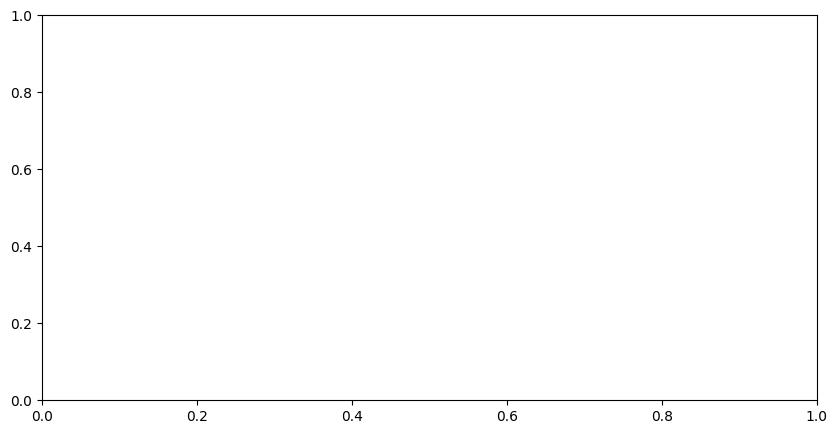

In [8]:
# Visualize loss and ROC-AUC
visualize_loss(training_history)

# Plot ROC and PR curves
plot_roc_curve_link(final_test_metrics['y_true'], final_test_metrics['y_scores'])
plot_precision_recall_link(final_test_metrics['y_true'], final_test_metrics['y_scores'])

# Predict gene-gene links
top_links = predict_gene_gene_links(
    trained_model, pyg_test, properties[0], properties[1], topk=10
)
for gene1, gene2, score in top_links:
    print(f"{gene1} - {gene2}: {score:.3f}")